## Setup

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer

from catboost import CatBoostRegressor

from datetime import datetime, timedelta

# import lightgbm as lgb

import warnings  # Supress warnings

warnings.filterwarnings("ignore")


## Load Dataset

In [40]:
train_raw = pd.read_csv("../../data/train_data.csv", parse_dates=["startdate"])
test_raw = pd.read_csv("../../data/test_data.csv", parse_dates=["startdate"])
submit = pd.read_csv("../../data/sample_solution.csv")
target = "contest-tmp2m-14d__tmp2m"


In [5]:
train_raw[target].describe()


count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

In [6]:
# more information about the data
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [10]:
# check the missing value
print(train_raw.isnull().sum())
# find columns with missing value, and how many rows are missing
print(train_raw.isnull().sum()[train_raw.isnull().sum() > 0])

index                                 0
lat                                   0
lon                                   0
startdate                             0
contest-pevpr-sfc-gauss-14d__pevpr    0
                                     ..
wind-vwnd-925-2010-16                 0
wind-vwnd-925-2010-17                 0
wind-vwnd-925-2010-18                 0
wind-vwnd-925-2010-19                 0
wind-vwnd-925-2010-20                 0
Length: 246, dtype: int64
nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64


A pic from other people:
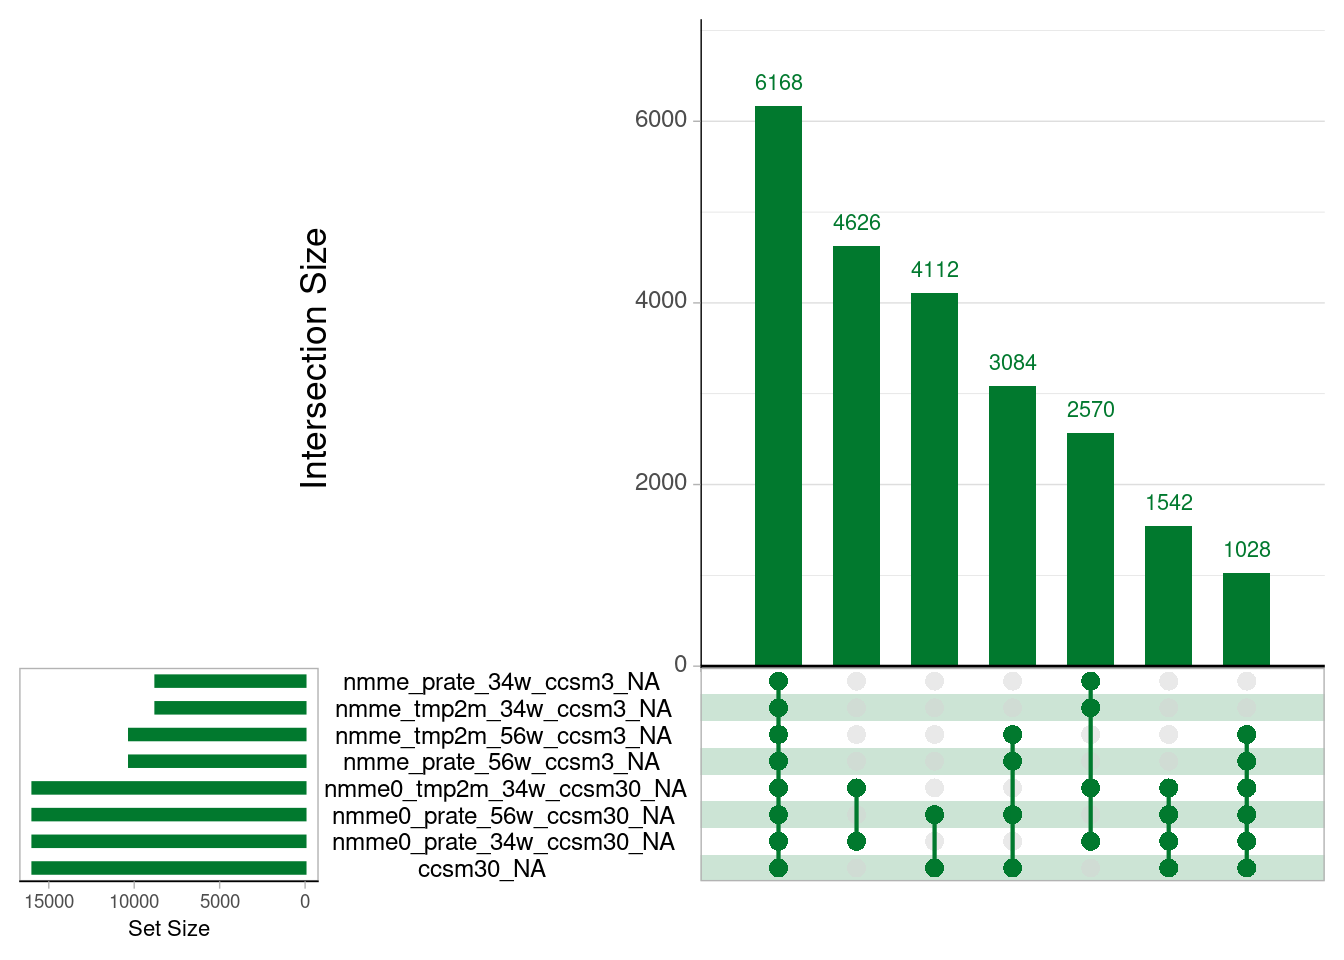

## Preprocessing

In [115]:
def location_nom(train, test):
    # Ref: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14

    train.loc[:, "lat"] = round(train.lat, scale)
    train.loc[:, "lon"] = round(train.lon, scale)
    test.loc[:, "lat"] = round(test.lat, scale)
    test.loc[:, "lon"] = round(test.lon, scale)

    all_df = pd.concat([train, test], axis=0)
    all_df["loc_group"] = all_df.groupby(["lat", "lon"]).ngroup()
    train = all_df.iloc[: len(train)]
    test = all_df.iloc[len(train) :].drop(target, axis=1)

    return train, test

def fill_na(df):
    df = df.sort_values(by=["loc_group", "startdate"]).ffill()
    return df

In [116]:
def fillin_na_and_save(train, test):
    train, test = location_nom(train, train)
    train = fill_na(train)
    test = fill_na(test)
    train.to_csv("../../data/train_data_filled.csv", index=False)
    test.to_csv("../../data/test_data_filled.csv", index=False)

train_raw = pd.read_csv("../../data/train_data.csv", parse_dates=["startdate"])
test_raw = pd.read_csv("../../data/test_data.csv", parse_dates=["startdate"])
fillin_na_and_save(train_raw, test_raw)


In [42]:
def drop_and_save(train, test):
    drop_cols = [target, "index", "startdate"] # "lat", "lon"]
    features = [col for col in train.columns if col not in drop_cols]
    train = train[features]
    test = test[features]
    train.to_csv("../../data/train_init.csv", index=False)
    test.to_csv("../../data/test_init.csv", index=False)

train_raw = pd.read_csv("../../data/train_data_filled.csv", parse_dates=["startdate"])
test_raw = pd.read_csv("../../data/test_data_filled.csv", parse_dates=["startdate"])
drop_and_save(train_raw, test_raw)


## Analyze Long & Lat: Region

In [35]:
# load train ,test init data
train_raw = pd.read_csv("../../data/train_init.csv")
test_raw = pd.read_csv("../../data/test_init.csv")


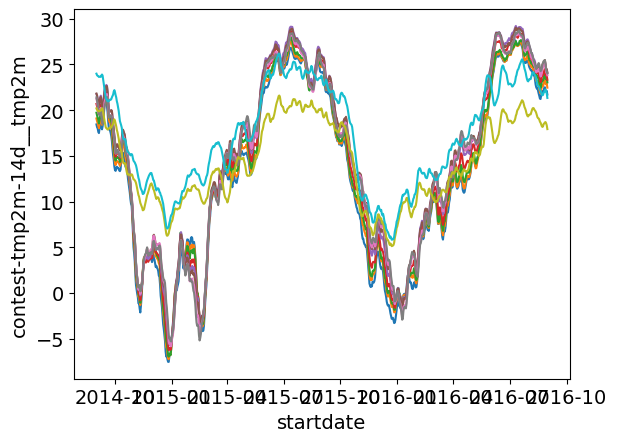

In [43]:
# plot the first feature column by location, looping over all values in loc_group
# for i in range(1, 100, 10):
for i in range(200, 210, 1):
    temp = train_raw[train_raw.loc_group == i]
    sns.lineplot(data=temp, x="startdate", y="contest-tmp2m-14d__tmp2m")
    # sns.lineplot(data=temp, x="startdate", y = 'nmme__tmp2m')


In [75]:
# plot the relation between distance and tmp difference
temperature_list = []
for loc_group in range(train_raw.loc_group.nunique()):
    temp = train_raw[train_raw.loc_group == loc_group]["contest-tmp2m-14d__tmp2m"]
    # print(f'what is this {temp.values}')
    # add temp.values as an element in temperature_list
    temp_list = np.array(temp.values)
    temperature_list.append(temp_list)
temperature_list = np.array(temperature_list)

dist = []
dist_long = []
dist_lat = []
Dtemp = []
while len(dist) < 5000:
    loc_1 = np.random.randint(0, train_raw.loc_group.nunique())
    loc_2 = np.random.randint(0, train_raw.loc_group.nunique())
    diff_long = (train_raw[train_raw.loc_group == loc_1]["lon"].iloc[0] - train_raw[train_raw.loc_group == loc_2]["lon"].iloc[0]).astype(float)
    diff_lat = (train_raw[train_raw.loc_group == loc_1]["lat"].iloc[0] - train_raw[train_raw.loc_group == loc_2]["lat"].iloc[0]).astype(float)
    distance = np.sqrt(diff_long**2 + diff_lat**2)
    dist_long.append(diff_long)
    dist_lat.append(diff_lat)
    dist.append(distance)
    dtemp = np.mean(np.abs(np.subtract(temperature_list[loc_1], temperature_list[loc_2])))
    Dtemp.append(dtemp)

    if distance > 0.8 and dtemp <= 1:
        print(f'temperture list: {temperature_list[loc_1]}')
        print(f'temperture list: {temperature_list[loc_2]}')
        print(f'loc_1: {loc_1}, loc_2: {loc_2}, distance: {distance}, Dtemp: {np.mean(np.abs(np.subtract(temperature_list[loc_1], temperature_list[loc_2])))}')
        temp1 = train_raw[train_raw.loc_group == loc_1]
        temp2 = train_raw[train_raw.loc_group == loc_2]
        sns.lineplot(data=temp1, x="startdate", y="contest-tmp2m-14d__tmp2m")
        sns.lineplot(data=temp2, x="startdate", y="contest-tmp2m-14d__tmp2m")
        break

    if len(dist) % 500 == 0:
        print(len(dist))




500
1000
1500
2000
2500
3000
3500
4000
4500
5000


<AxesSubplot: >

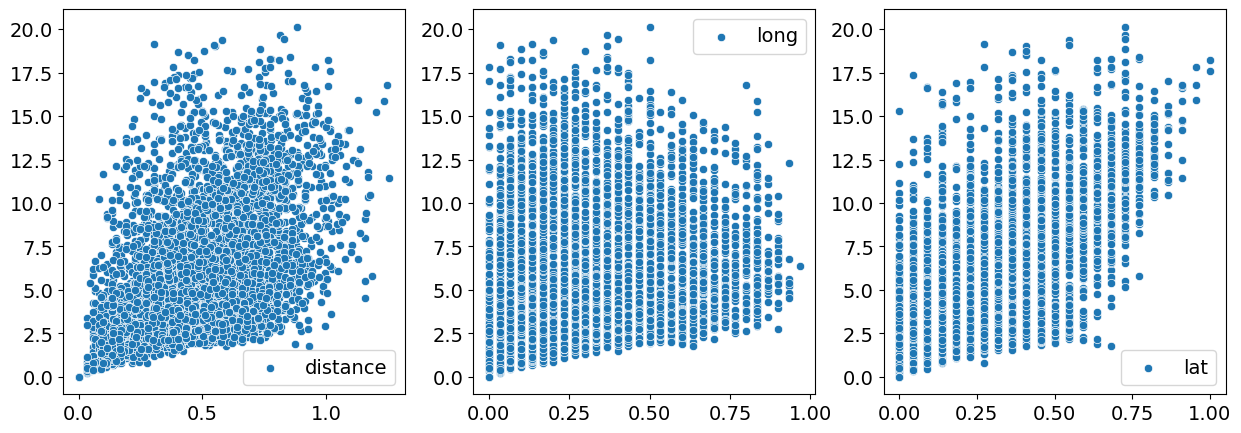

In [78]:
# draw three plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x=dist, y=Dtemp, ax=ax[0], label = 'distance')
sns.scatterplot(x=np.abs(dist_long), y=Dtemp, ax=ax[1], label = 'long')
sns.scatterplot(x=np.abs(dist_lat), y=Dtemp, ax=ax[2], label = 'lat')

rd1: [0.02642363 0.02227108 0.03981528 ... 0.00830957 0.03040081 0.00529576], rd2: [0.04170695 0.00551705 0.01559032 ... 0.01945638 0.02753145 0.0454651 ]


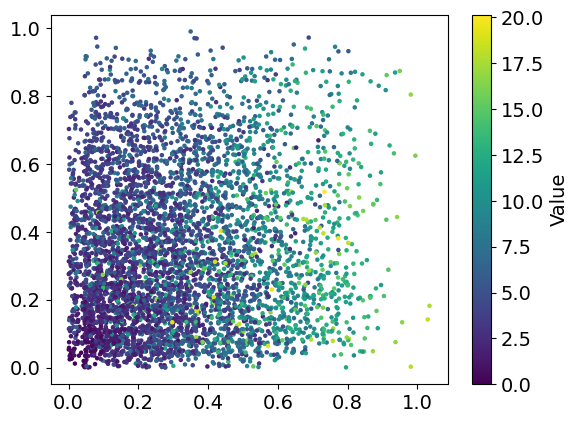

In [89]:
# generate two small random numbers
rd1 = np.random.rand(len(dist_lat)) / 20
rd2 = np.random.rand(len(dist_long)) / 20
print(f'rd1: {rd1}, rd2: {rd2}')
# a heat map
fig, ax = plt.subplots()
sc = ax.scatter(np.abs(dist_lat) + rd1, np.abs(dist_long) + rd2, c=Dtemp, cmap='viridis', s = 5)
cbar = fig.colorbar(sc)
cbar.set_label('Value')


In [95]:
def categorical_encode(train, test):
    le = LabelEncoder()
    train["climateregions__climateregion"] = le.fit_transform(
        train["climateregions__climateregion"]
    )
    test["climateregions__climateregion"] = le.transform(
        test["climateregions__climateregion"]
    )
    return train, test


def add_season(df):
    month_to_season = {
        1: 0,
        2: 0,
        3: 1,
        4: 1,
        5: 1,
        6: 2,
        7: 2,
        8: 2,
        9: 3,
        10: 3,
        11: 3,
        12: 0,
    }
    df["season"] = df["month"].apply(lambda x: month_to_season[x])


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclical(df):
    # encode the day with a period of 365
    df["day_of_year_sin"] = sin_transformer(365).fit_transform(df["day_of_year"])
    df["day_of_year_cos"] = cos_transformer(365).fit_transform(df["day_of_year"])

    # encode the week with a period of 52
    df["week_sin"] = sin_transformer(52).fit_transform(df["week"])
    df["week_cos"] = cos_transformer(52).fit_transform(df["week"])

    # encode the month with a period of 12
    df["month_sin"] = sin_transformer(12).fit_transform(df["month"])
    df["month_cos"] = cos_transformer(12).fit_transform(df["month"])

    # encode the season with a period of 4
    df["season_sin"] = sin_transformer(4).fit_transform(df["season"])
    df["season_cos"] = cos_transformer(4).fit_transform(df["season"])

    # encode the quarter with a period of 4
    df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"])
    df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"])


def create_time_features(df):
    df["year"] = df["startdate"].dt.year
    df["month"] = df["startdate"].dt.month
    df["week"] = df.startdate.dt.weekofyear
    df["quarter"] = df.startdate.dt.quarter

    df["day_of_week"] = df["startdate"].dt.dayofweek
    df["week_of_year"] = df["startdate"].dt.isocalendar().week
    df["day_of_year"] = df["startdate"].dt.dayofyear

    add_season(df)
    encode_cyclical(df)
    return df


def feature_engineering(train_raw, test_raw):
    train, test = create_time_features(train_raw), create_time_features(test_raw)
    train, test = categorical_encode(train, test)
    return train, test


In [96]:
train_add0, test_add0 = feature_engineering(train_raw, test_raw)
# store them
train_add0.to_csv('../../data/train_add0.csv', index=False)
test_add0.to_csv('../../data/test_add0.csv', index=False)

## Train and Validation

In [ ]:
train_use = pd.read_csv('../../data/train_add0.csv')
test_use = pd.read_csv('../../data/test_add0.csv')

In [101]:
# output some info of train_use
# print(train_use.info())
# print(train_use.describe())
# train_use.head()

               index            lat            lon  \
count  375734.000000  375734.000000  375734.000000   
mean   187866.500000       0.592766       0.517964   
std    108465.207359       0.251744       0.272059   
min         0.000000       0.000000       0.000000   
25%     93933.250000       0.409091       0.300000   
50%    187866.500000       0.590909       0.533333   
75%    281799.750000       0.818182       0.766667   
max    375733.000000       1.000000       1.000000   

       contest-pevpr-sfc-gauss-14d__pevpr  nmme0-tmp2m-34w__cancm30  \
count                       375734.000000             375734.000000   
mean                           276.744064                 10.801682   
std                            198.085182                 10.952417   
min                             -2.310000                -14.960000   
25%                            104.062500                  1.550000   
50%                            250.320000                  9.950000   
75%             

In [106]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [113]:
def train(train, test, target = 'contest-tmp2m-14d__tmp2m'):
    train_X = train.drop([target, 'startdate'], axis=1)
    train_y = train[target]
    test_X = test
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.13, random_state=42)
    print(f'Train_shape: {train_X.shape}    |   Val_shape: {val_X.shape}    |   Test_shape: {test.shape}')
    model = CatBoostRegressor(iterations=500, learning_rate=0.02, depth=10, eval_metric='RMSE', random_seed=42)#, bagging_temperature=0.2, od_type='Iter', metric_period=75, od_wait=100)
    model.fit(train_X, train_y, eval_set=(val_X, val_y), use_best_model=True, verbose=100)
    y_pred = model.predict(val_X)
    print(f'RMSE: {rmse(val_y, y_pred)}')
    return model, y_pred

In [114]:
model, y_pred = train(train_use, test_use)

Train_shape: (326888, 263)    |   Val_shape: (48846, 263)    |   Test_shape: (375734, 264)
0:	learn: 9.6895390	test: 9.6798545	best: 9.6798545 (0)	total: 170ms	remaining: 1m 24s


KeyboardInterrupt: 

## Feature Importance

Text(0.5, 1.0, 'Feature Importance')

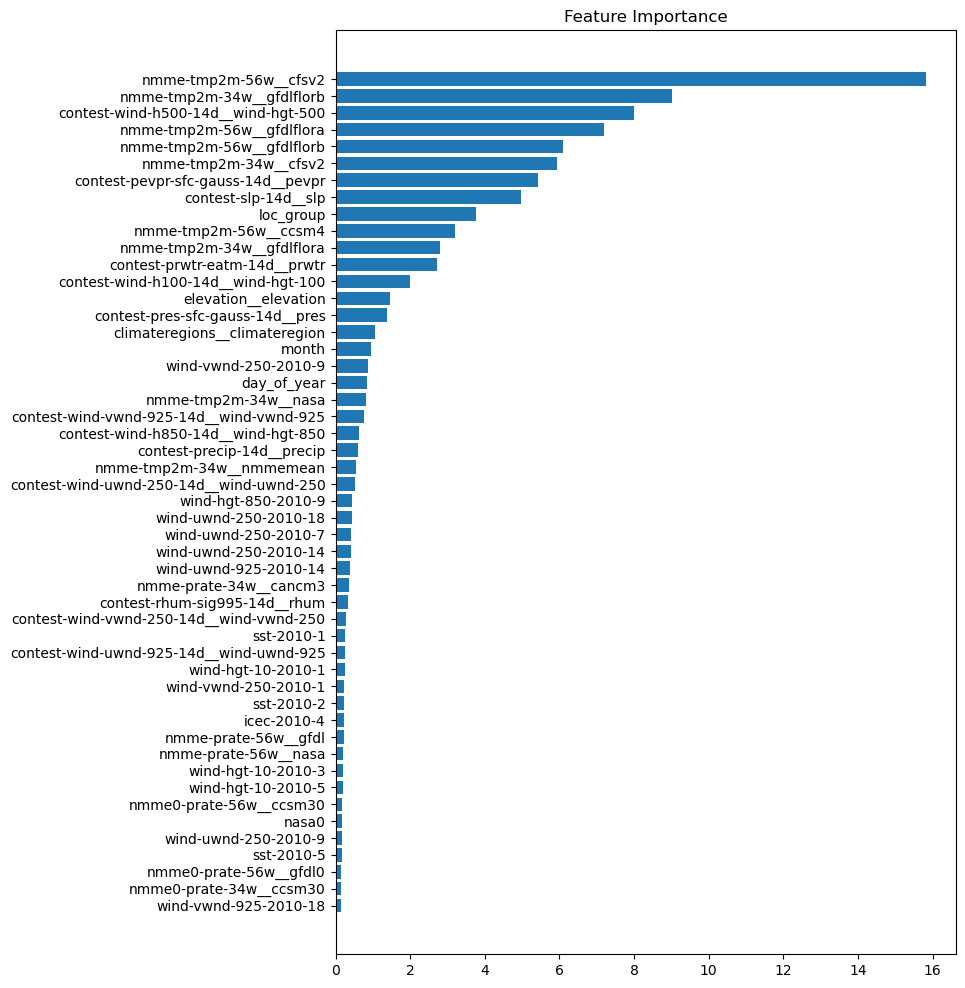

In [21]:
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

Original sample:
...

## Submit

In [22]:
submit = pd.read_csv("../../data/sample_solution.csv")
def generate_submission(model, name):
    submit[target] = model.predict(X_test)
    submit.to_csv(f'../../submissions/{name}.csv', index=False)

In [23]:
generate_submission(model, 'catboost0')